In [ ]:
%matplotlib inline

In [1]:
import numpy as np
import os, time, shutil
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [2]:
# https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab/48919022
import os
from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)
import utils
help(utils)

torch.manual_seed(42)
np.random.seed(42)

Saving utils.py to utils.py
Help on module utils:

NAME
    utils

FUNCTIONS
    avg_across_z(img, normalize=False)
        Returns a new image where each pixel
        intensity is the average for that pixel across
        all images in the z-stack.
    
    get_img_at_t(t, img)
    
    get_max_pixel(embryos, data_path)
        Obtains the maximum pixel value across a set of embryos
        embryos: subset of p_embryo... train, val, test
        data_path: path from which to load processed np embryo data
    
    get_z_slice(z, img)
    
    max_across_z(img, normalize=False)
        Returns a new image where each pixel
        intensity is the maximum for that pixel across
        all images in the z-stack.
    
    middle_z(img)
    
    min_across_z(img, normalize=False)
        Returns a new image where each pixel
        intensity is the minimum for that pixel across
        all images in the z-stack.
    
    normalize(img)
        Normalizes pixel values across all images in i

# 4. Transfer Learning with Your Own Image Dataset

Dataset size is a big factor in the performance of deep learning models.
``ImageNet`` has over one million labeled images, but
we often don't have so much labeled data in other domains.
Training a deep learning models on small datasets may lead to severe overfitting.

Transfer learning is a technique that addresses this problem.
The idea is simple: we can start training with a pre-trained model,
instead of starting from scratch.
As Isaac Newton said, "If I have seen further it is by standing on the
shoulders of Giants".


In [3]:
import os
from google.colab import files, drive   
import pandas as pd

# mount the google drive to my Colab session
drive.mount('/content/gdrive')
# use the google drive in my Colab session
print(os.listdir('/content/gdrive/Shared drives/Embryo_data'))

home_path = '/content/gdrive/Shared drives/Embryo_data'

Mounted at /content/gdrive
['mxnet_cnn2d_embryo_58_fine_tune_data_aug_ResNet50_v2_order_random.ipynb', 'Embryo3', 'Embryo12', 'Embryo13', 'Embryo16', 'Embryo19', 'Embryo18', 'Embryo24', 'Embryo39', 'Embryo42', 'Embryo46', 'Embryo47', 'Embryo23', 'Embryo33', 'Embryo25', 'Embryo95', 'Embryo97', 'Embryo96', 'Embryo98', 'Embryo101', 'Embryo99', 'Embryo100', 'Embryo102', 'Embryo76', 'Embryo78', 'Embryo81', 'Embryo79', 'Embryo80', 'Embryo84', 'Embryo85', 'Embryo87', 'Embryo88', 'Embryo92', 'Embryo94', 'Embryo93', 'embryo_info_CS101.xlsx', 'data', 'processed', 'models', 'pix2pix_PyTorch-GAN.ipynb', 'annotation.xlsx', 'Embryo110', 'Embryo109', 'Embryo111', 'Embryo113', 'Embryo112', 'Embryo114', 'Embryo116', 'Embryo115', 'Embryo117', 'Embryo118', 'Embryo119', 'Embryo120', 'Embryo103', 'Embryo104', 'Embryo105', 'Embryo107', 'Embryo106', 'Embryo108', 'pix2pix_output', 'images']


## Hyperparameters

First, let's import all other necessary libraries.



We set the hyperparameters as following:



In [4]:
classes = 2

epochs = 60
per_device_batch_size = 16

num_gpus = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}
batch_size = per_device_batch_size * max(num_gpus, 1)
log_interval = 100
step = 1
lr = 0.1
gamma = 0.7

Things to keep in mind:

1. ``epochs = 5`` is just for this tutorial with the tiny dataset. please change it to a larger number in your experiments, for instance 40.
2. ``per_device_batch_size`` is also set to a small number. In your experiments you can try larger number like 64.
3. remember to tune ``num_gpus`` and ``num_workers`` according to your machine.
4. A pre-trained model is already in a pretty good status. So we can start with a small ``lr``.

## Data Augmentation

In transfer learning, data augmentation can also help.
We use the following augmentation in training:

2. Randomly crop the image and resize it to 224x224
3. Randomly flip the image horizontally
4. Randomly jitter color and add noise
5. Transpose the data from height*width*num_channels to num_channels*height*width, and map values from [0, 255] to [0, 1]
6. Normalize with the mean and standard deviation from the ImageNet dataset.




In [5]:
transform_train = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])


With the data augmentation functions, we can define our data loaders:



In [6]:
class ImageFolderDataset(Dataset):
    """A dataset for loading image files stored in a folder structure.

    like::

        root/car/0001.jpg
        root/car/xxxa.jpg
        root/car/yyyb.jpg
        root/bus/123.jpg
        root/bus/023.jpg
        root/bus/wwww.jpg

    Parameters
    ----------
    root : str
        Path to root directory.
    flag : {0, 1}, default 1
        If 0, always convert loaded images to greyscale (1 channel).
        If 1, always convert loaded images to colored (3 channels).
    transform : callable, default None
        A function that takes data and label and transforms them::

            transform = lambda data, label: (data.astype(np.float32)/255, label)

    Attributes
    ----------
    synsets : list
        List of class names. `synsets[i]` is the name for the integer label `i`
    items : list of tuples
        List of all images in (filename, label) pairs.
    """
    def __init__(self, root, flag=1, transform=None):
        self._root = os.path.expanduser(root)
        self._flag = flag
        self._transform = transform
        self._exts = ['.jpg', '.jpeg', '.png']
        self._list_images(self._root)

    def _list_images(self, root):
        self.items = []

        for filename in sorted(os.listdir(root)):
          filepath = os.path.join(root, filename)
          self.items.append(filepath)

    def __getitem__(self, idx):
        ind = self.items[idx].find('embryo')
        [embryo_num, embryo_t, label] = [int(num) for num in self.items[idx][ind:-4].split('_')[1:]]
        img = Image.open(self.items[idx]).convert('RGB')
        if self._transform is not None:
            img = self._transform(img)
        return {'img': img, 'label': label, 'embryo_num': embryo_num, 'embryo_t': embryo_t}

    def __len__(self):
        return len(self.items)

In [7]:
embryo_type = 'bf'
processed_path = f'{home_path}/processed'
train_path = f'{processed_path}/pix2pix/train/{embryo_type}_data'
val_path = f'{processed_path}/pix2pix/val/{embryo_type}_data'
test_path = f'{processed_path}/pix2pix/test/{embryo_type}_data'

train_dataset = ImageFolderDataset(train_path, transform=transform_train)
val_dataset = ImageFolderDataset(val_path, transform=transform_train)
test_dataset = ImageFolderDataset(test_path, transform=transform_test)

train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_data = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

Note that only ``train_data`` uses ``transform_train``, while
``val_data`` and ``test_data`` use ``transform_test`` to produce deterministic
results for evaluation.

## Model and Trainer

We use a pre-trained ``ResNet50_v2`` model, which has balanced accuracy and
computation cost.



In [8]:
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, classes)
model.to(device)

optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=step, gamma=gamma)

# Path to save trained models to, create folder
model_name = 'ResNet50_v2'
model_save_path = os.path.join(home_path, 'models', f'{model_name}-{embryo_type}-batch{per_device_batch_size}-lr{lr}-step{step}-gamma{gamma}')
if not os.path.isdir(model_save_path):
  os.mkdir(model_save_path)
else:
  print(model_save_path, 'already exists')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Here's an illustration of the pre-trained model
and our newly defined model:

|image-model|

Specifically, we define the new model by::

1. load the pre-trained model
2. re-define the output layer for the new task
3. train the network

This is called "fine-tuning", i.e. we have a model trained on another task,
and we would like to tune it for the dataset we have in hand.

We define a evaluation function for validation and testing.



## Training Loop

Following is the main training loop. It is the same as the loop in
`CIFAR10 <dive_deep_cifar10.html>`__
and ImageNet.

<div class="alert alert-info"><h4>Note</h4><p>Once again, in order to go through the tutorial faster, we are training on a small
    subset of the original ``MINC-2500`` dataset, and for only 5 epochs. By training on the
    full dataset with 40 epochs, it is expected to get accuracy around 80% on test data.</p></div>



In [9]:
def train(model, device, train_loader, optimizer, epoch):
    '''
    This is your training function. When you call this function, the model is
    trained for 1 epoch.
    '''
    criterion = nn.CrossEntropyLoss()
    model.train()# Set the model to training mode
    losses = []
    for batch_idx, data0 in enumerate(train_loader):
        data = data0['img']
        target = data0['label']
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()               # Clear the gradient
        output = model(data)                # Make predictions
        loss = criterion(output, target)   # Compute loss
        loss.backward()                     # Gradient computation
        optimizer.step()                    # Perform a single optimization step
        losses.append(loss.item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataset),
                100. * batch_idx / len(train_dataset), losses[-1]))
    return np.mean(losses)

In [10]:
def test(model, device, test_loader):
    criterion = nn.CrossEntropyLoss(reduction='sum')
    model.eval()    # Set the model to inference mode
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():   # For the inference step, gradient is not computed
        for data0 in test_loader:
            data = data0['img']
            target = data0['label']
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += len(target)

    test_loss /= total

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, total,
        100. * correct / total))
    return test_loss, correct / total

In [11]:
train_losses = []
test_losses = []
start = time.time()
for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_data, optimizer, epoch)
    test_loss = test(model, device, val_data)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    scheduler.step()    # learning rate scheduler
    torch.save(model.state_dict(), f"{model_save_path}/epoch{epoch}.pt")
print('Train Time:', time.time()-start)
np.save(f"{model_save_path}/train_loss.npy", np.array(train_losses))
np.save(f"{model_save_path}/test_loss.npy", np.array(test_losses))

print("\nFinal Performance!")
print("Training Set:")
test(model, device, train_data)
print("Validation Set:")
test(model, device, val_data)

Train Epoch: 1 [0/1900 (0%)]	Loss: 0.719597
Train Epoch: 1 [1600/1900 (5%)]	Loss: 0.172699

Test set: Average loss: 2.5152, Accuracy: 102/312 (33%)

Train Epoch: 2 [0/1900 (0%)]	Loss: 0.061003
Train Epoch: 2 [1600/1900 (5%)]	Loss: 0.075261

Test set: Average loss: 0.2657, Accuracy: 264/312 (85%)

Train Epoch: 3 [0/1900 (0%)]	Loss: 0.035908
Train Epoch: 3 [1600/1900 (5%)]	Loss: 0.020962

Test set: Average loss: 0.3232, Accuracy: 280/312 (90%)

Train Epoch: 4 [0/1900 (0%)]	Loss: 0.012616
Train Epoch: 4 [1600/1900 (5%)]	Loss: 0.008348

Test set: Average loss: 0.1677, Accuracy: 285/312 (91%)

Train Epoch: 5 [0/1900 (0%)]	Loss: 0.006018
Train Epoch: 5 [1600/1900 (5%)]	Loss: 0.183309

Test set: Average loss: 0.2425, Accuracy: 280/312 (90%)

Train Epoch: 6 [0/1900 (0%)]	Loss: 0.001409
Train Epoch: 6 [1600/1900 (5%)]	Loss: 0.000935

Test set: Average loss: 0.1856, Accuracy: 290/312 (93%)

Train Epoch: 7 [0/1900 (0%)]	Loss: 0.013225
Train Epoch: 7 [1600/1900 (5%)]	Loss: 0.003256

Test set: Aver

(0.14737917377780646, 0.9487179487179487)

0


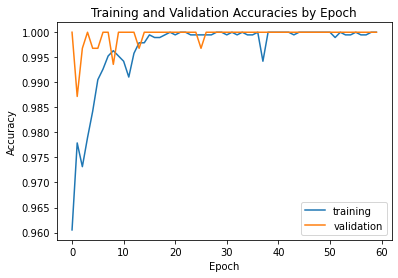

In [ ]:
# Plot training with validation
plt.plot(range(epochs), train_acc_lst, label='training')
plt.plot(range(epochs), val_acc_lst, label='validation')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracies by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

print(np.argmax(val_acc_lst))

In [13]:
# Loading best model parameters from file
best_epoch = 50
best_model_file_name = f'{model_save_path}/epoch{best_epoch}.pt'
model.load_state_dict(torch.load(best_model_file_name))
# run on test data
_, test_acc = test(model, device, test_data)
print('[Finished] Test-acc: %.3f' % (test_acc))


Test set: Average loss: 0.5172, Accuracy: 395/449 (88%)

[Finished] Test-acc: 0.880


## Next

Now that you have learned to muster the power of transfer
learning, to learn more about training a model on
ImageNet, please read `this tutorial <dive_deep_imagenet.html>`__.

The idea of transfer learning is the basis of
`object detection <../examples_detection/index.html>`_ and
`semantic segmentation <../examples_segmentation/index.html>`_,
the next two chapters of our tutorial.

.. |image-minc| image:: https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/datasets/MINC-2500.png
.. |image-model| image:: https://zh.gluon.ai/_images/fine-tuning.svg

